In [11]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
cifar10_full = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=False, transform=transform_train)
train_size = int(0.9 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
cifar10_train, cifar10_val = random_split(cifar10_full, [train_size, val_size])

cifar10_test = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=False, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [13]:
# BasicBlock for ResNet-18 with dropout
class BasicBlockRes18(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, dropout_p=0.3):
        super(BasicBlockRes18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_p)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.dropout(out)
        out = self.relu(out)
        return out

# Definition of ResNet-18 with dropout
class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2, stride=1, dropout_p=dropout_p)
        self.layer2 = self._make_layer(128, 2, stride=2, dropout_p=dropout_p)
        self.layer3 = self._make_layer(256, 2, stride=2, dropout_p=dropout_p)
        self.layer4 = self._make_layer(512, 2, stride=2, dropout_p=dropout_p)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * BasicBlockRes18.expansion, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride, dropout_p):
        layers = []
        layers.append(BasicBlockRes18(self.in_channels, out_channels, stride, dropout_p))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlockRes18(self.in_channels, out_channels, stride=1, dropout_p=dropout_p))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [14]:
# load model
model = ResNet18(num_classes=10).to(device)
print(model)

SimplifiedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected AlexNet parameter count:", count_parameters(model))

Selected AlexNet parameter count: 620362


In [16]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: Train Loss: 1.7212, Val Loss: 1.6312, Val Acc: 0.4734
Epoch 2/30: Train Loss: 1.4120, Val Loss: 1.4524, Val Acc: 0.5376
Epoch 3/30: Train Loss: 1.2589, Val Loss: 1.3342, Val Acc: 0.5988
Epoch 4/30: Train Loss: 1.1596, Val Loss: 1.2358, Val Acc: 0.6236
Epoch 5/30: Train Loss: 1.0921, Val Loss: 1.1533, Val Acc: 0.6580
Epoch 6/30: Train Loss: 1.0413, Val Loss: 1.1156, Val Acc: 0.6524
Epoch 7/30: Train Loss: 1.0073, Val Loss: 1.0406, Val Acc: 0.6984
Epoch 8/30: Train Loss: 0.9753, Val Loss: 0.9871, Val Acc: 0.7002
Epoch 9/30: Train Loss: 0.9452, Val Loss: 0.9627, Val Acc: 0.7066
Epoch 10/30: Train Loss: 0.9157, Val Loss: 0.9386, Val Acc: 0.7132
Epoch 11/30: Train Loss: 0.9011, Val Loss: 0.9445, Val Acc: 0.7016
Epoch 12/30: Train Loss: 0.8756, Val Loss: 0.9096, Val Acc: 0.7208
Epoch 13/30: Train Loss: 0.8718, Val Loss: 0.8724, Val Acc: 0.7368
Epoch 14/30: Train Loss: 0.8522, Val Loss: 0.8627, Val Acc: 0.7230
Epoch 15/30: Train Loss: 0.8332, Val Loss: 0.8768, Val Acc: 0.7184
Epoc

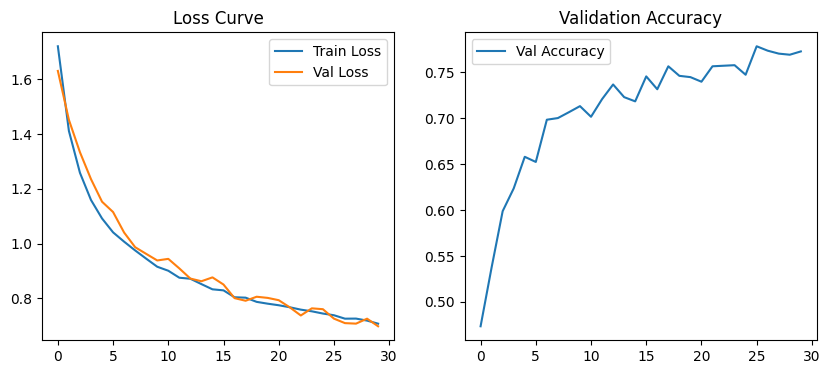

In [17]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p3_10_dropout_ResNet18_results.png")
plt.show()

In [18]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [19]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar10_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.7891458512562498
Test Recall: 0.786
Test F1 Score: 0.7809346194235456

Confusion Matrix:
 [[846  10  28   3   7   2  10  13  59  22]
 [ 20 872   2   1   0   2  15   1  22  65]
 [ 75   0 640  24  83  56  95  19   5   3]
 [ 25   1  56 431  65 237 131  29  17   8]
 [ 18   1  39  21 787  21  72  35   6   0]
 [ 12   0  31  73  48 764  44  26   0   2]
 [  9   1  17   9  10   8 939   4   3   0]
 [ 19   0  26  21  53  51  10 819   0   1]
 [ 53  10   3   4   4   2   7   4 905   8]
 [ 35  38   2  11   6   0  11  16  24 857]]

Classification Report:
               precision    recall  f1-score   support

    airplane       0.76      0.85      0.80      1000
  automobile       0.93      0.87      0.90      1000
        bird       0.76      0.64      0.69      1000
         cat       0.72      0.43      0.54      1000
        deer       0.74      0.79      0.76      1000
         dog       0.67      0.76      0.71      1000
        frog       0.70      0.94      0.80      1000
   

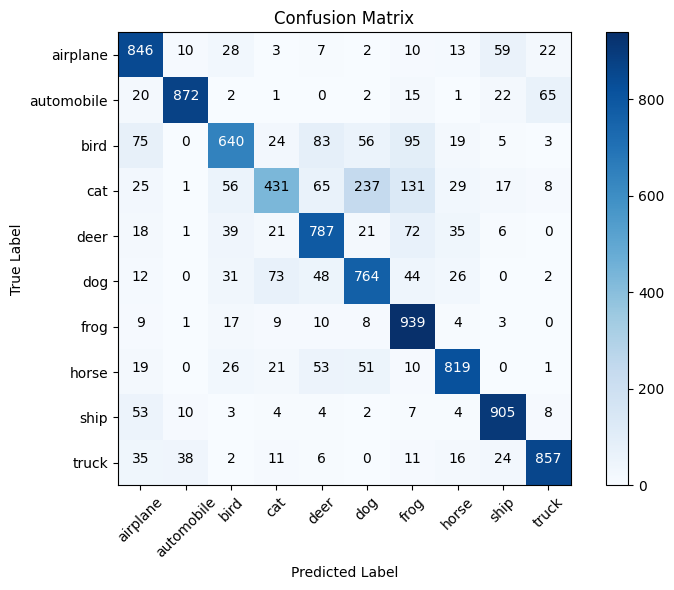

In [20]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar10_test.classes))
plt.xticks(tick_marks, cifar10_test.classes, rotation=45)
plt.yticks(tick_marks, cifar10_test.classes)

# Annotate the confusion matrix cells with the numeric values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p3_10_dropout_ResNet18_matrix.png")
plt.show()